In [1]:
import os
import sys
import pandas as pd
import numpy as np
from pandas import Series, DataFrame

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
pd.set_option('display.max_columns', 500) 
pd.set_option('display.max_rows', 500) 

In [4]:
# pip install lightgbm --install-option=--gpu


# 前処理

In [5]:
status = pd.read_csv('status.csv') 
status["date"] = pd.to_datetime(status[["year", "month", "day"]])

station = pd.read_csv("station.csv")
station = station.drop(["installation_date",], axis=1)

weather = pd.read_csv('weather.csv') 
weather['date'] = pd.to_datetime(weather['date'],format="%Y-%m-%d")
weather = weather.drop(["events",                                     
                        "max_temperature","min_temperature","mean_temperature",
                        "max_dew_point","min_dew_point","mean_dew_point",
                        "max_humidity","min_humidity","mean_humidity",
                        "max_sea_level_pressure","mean_sea_level_pressure","min_sea_level_pressure",
                        "max_visibility","min_visibility",
                        "max_wind_Speed","cloud_cover","wind_dir_degrees",                                            
#                         "mean_visibility",
#                         "mean_wind_speed",                       
#                         "precipitation",                        
                       ], axis=1)

In [6]:
#曜日を追加する
def get_week(dt):
    w_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    return(w_list[dt.weekday()])
status["weekday"] = status["date"].apply(get_week)

status.head(2)

,id,year,month,day,hour,station_id,bikes_available,predict,date,weekday
0,0,2013,9,1,0,0,11.0,0,2013-09-01,Sunday
1,1,2013,9,1,1,0,11.0,0,2013-09-01,Sunday


In [7]:
station.head(2)

,station_id,lat,long,dock_count,city
0,0,37.32973,-121.90178,27,city1
1,1,37.33070,-121.88898,15,city1


In [8]:
weather.head(2)

,date,mean_visibility,mean_wind_speed,precipitation
0,2013-09-01,10,4,0.0
1,2013-09-02,10,4,0.0


In [9]:
#"date"でstatus,station,weatherをmerge
_ = pd.merge(status, station, on = "station_id")
_ = pd.merge(_, weather, on = "date")

In [10]:
_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1226400 entries, 0 to 1226399
Data columns (total 17 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   id               1226400 non-null  int64         
 1   year             1226400 non-null  int64         
 2   month            1226400 non-null  int64         
 3   day              1226400 non-null  int64         
 4   hour             1226400 non-null  int64         
 5   station_id       1226400 non-null  int64         
 6   bikes_available  809995 non-null   float64       
 7   predict          1226400 non-null  int64         
 8   date             1226400 non-null  datetime64[ns]
 9   weekday          1226400 non-null  object        
 10  lat              1226400 non-null  float64       
 11  long             1226400 non-null  float64       
 12  dock_count       1226400 non-null  int64         
 13  city             1226400 non-null  object        
 14  me

In [11]:
_.head(2)

,id,year,month,day,hour,station_id,bikes_available,predict,date,weekday,lat,long,dock_count,city,mean_visibility,mean_wind_speed,precipitation
0,0,2013,9,1,0,0,11.0,0,2013-09-01,Sunday,37.32973,-121.90178,27,city1,10,4,0.0
1,1,2013,9,1,1,0,11.0,0,2013-09-01,Sunday,37.32973,-121.90178,27,city1,10,4,0.0


In [12]:
_.shape

(1226400, 17)

In [13]:
#"city"と"weekday"をone-hot化
_ = pd.get_dummies(_, dummy_na=False) 

In [14]:
_.head(2)

,id,year,month,day,hour,station_id,bikes_available,predict,date,lat,long,dock_count,mean_visibility,mean_wind_speed,precipitation,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,city_city1,city_city2,city_city3,city_city4,city_city5
0,0,2013,9,1,0,0,11.0,0,2013-09-01,37.32973,-121.90178,27,10,4,0.0,0,0,0,1,0,0,0,1,0,0,0,0
1,1,2013,9,1,1,0,11.0,0,2013-09-01,37.32973,-121.90178,27,10,4,0.0,0,0,0,1,0,0,0,1,0,0,0,0


In [15]:
# "train"と"test"を区分
train = _.loc[_["predict"] == 0]
test = _.loc[_["predict"] == 1]

In [16]:
train.shape

(1033200, 27)

In [17]:
train.head(2)

,id,year,month,day,hour,station_id,bikes_available,predict,date,lat,long,dock_count,mean_visibility,mean_wind_speed,precipitation,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,city_city1,city_city2,city_city3,city_city4,city_city5
0,0,2013,9,1,0,0,11.0,0,2013-09-01,37.32973,-121.90178,27,10,4,0.0,0,0,0,1,0,0,0,1,0,0,0,0
1,1,2013,9,1,1,0,11.0,0,2013-09-01,37.32973,-121.90178,27,10,4,0.0,0,0,0,1,0,0,0,1,0,0,0,0


In [18]:
train.isna().any(axis=0)

id                   False
year                 False
month                False
day                  False
hour                 False
station_id           False
bikes_available       True
predict              False
date                 False
lat                  False
long                 False
dock_count           False
mean_visibility      False
mean_wind_speed      False
precipitation        False
weekday_Friday       False
weekday_Monday       False
weekday_Saturday     False
weekday_Sunday       False
weekday_Thursday     False
weekday_Tuesday      False
weekday_Wednesday    False
city_city1           False
city_city2           False
city_city3           False
city_city4           False
city_city5           False
dtype: bool

In [19]:
test.isna().any(axis=0)

id                   False
year                 False
month                False
day                  False
hour                 False
station_id           False
bikes_available       True
predict              False
date                 False
lat                  False
long                 False
dock_count           False
mean_visibility      False
mean_wind_speed      False
precipitation        False
weekday_Friday       False
weekday_Monday       False
weekday_Saturday     False
weekday_Sunday       False
weekday_Thursday     False
weekday_Tuesday      False
weekday_Wednesday    False
city_city1           False
city_city2           False
city_city3           False
city_city4           False
city_city5           False
dtype: bool

In [20]:
#trainの欠失値を削除
train = train.dropna(subset = ["bikes_available"])
train.shape

(809995, 27)

In [21]:
#"yearmonth"を追加
df_m_s = train[train['month'] < 10].copy()
df_m_b = train[train['month'] >= 10].copy()
df_m_s['yearmonth'] = df_m_s['year'].astype(str) + ('0' + df_m_s['month'].astype(str))
df_m_b['yearmonth'] = df_m_b['year'].astype(str) + df_m_b['month'].astype(str)
train = pd.concat([df_m_s, df_m_b])

test = test.copy()
df_m_s = test[test['month'] < 10].copy()
df_m_b = test[test['month'] >= 10].copy()
df_m_s['yearmonth'] = df_m_s['year'].astype(str) + ('0' + df_m_s['month'].astype(str))
df_m_b['yearmonth'] = df_m_b['year'].astype(str) + df_m_b['month'].astype(str)
test = pd.concat([df_m_s, df_m_b])

In [22]:
train.head(2)

,id,year,month,day,hour,station_id,bikes_available,predict,date,lat,long,dock_count,mean_visibility,mean_wind_speed,precipitation,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,city_city1,city_city2,city_city3,city_city4,city_city5,yearmonth
0,0,2013,9,1,0,0,11.0,0,2013-09-01,37.32973,-121.90178,27,10,4,0.0,0,0,0,1,0,0,0,1,0,0,0,0,201309
1,1,2013,9,1,1,0,11.0,0,2013-09-01,37.32973,-121.90178,27,10,4,0.0,0,0,0,1,0,0,0,1,0,0,0,0,201309


In [23]:
test.head(2)

,id,year,month,day,hour,station_id,bikes_available,predict,date,lat,long,dock_count,mean_visibility,mean_wind_speed,precipitation,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,city_city1,city_city2,city_city3,city_city4,city_city5,yearmonth
613201,8761,2014,9,1,1,0,NaN,1,2014-09-01,37.32973,-121.90178,27,10,5,0.0,0,1,0,0,0,0,0,1,0,0,0,0,201409
613202,8762,2014,9,1,2,0,NaN,1,2014-09-01,37.32973,-121.90178,27,10,5,0.0,0,1,0,0,0,0,0,1,0,0,0,0,201409


In [24]:
#trainの年-月をチェック
groupby = train.groupby("yearmonth").apply(lambda x: len(x)).reset_index()
groupby.columns = ["train_yearmonth","numbers"]
groupby = groupby.sort_values("train_yearmonth", ascending = True)
print(groupby["numbers"].sum())
groupby

809995


,train_yearmonth,numbers
0,201309,46080
1,201310,47616
2,201311,46080
3,201312,47664
4,201401,50083
5,201402,45900
6,201403,51336
7,201404,50196
8,201405,52080
9,201406,50400


In [25]:
#testの年-月をチェック
groupby = test.groupby("yearmonth").apply(lambda x: len(x)).reset_index()
groupby.columns = ["test_yearmonth","numbers"]
print(groupby["numbers"].sum())
groupby

193200


,test_yearmonth,numbers
0,201409,16100
1,201410,16100
2,201411,16100
3,201412,16100
4,201501,16100
5,201502,16100
6,201503,16100
7,201504,16100
8,201505,16100
9,201506,16100





# 学習＋予測

In [26]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

cv_score = []
#201409testを予測する場合、201407以前のtrainデータで訓練，201408のtrainデータで検証，
#201410testを予測する場合、201408以前のtrainデータで訓練，201409のtrainデータで検証，
#このように繰り返す
def train_predict(year_month):
    #train,validation,test sets
    if year_month == "201501":
        valid5 = train.loc[train["yearmonth"] == "201412"]
        train5 = train.loc[train["yearmonth"] < "201412"]
    else:
        valid5 = train.loc[train["yearmonth"] == str(int(year_month) - 1)]
        train5 = train.loc[train["yearmonth"] < str(int(year_month) - 1)]
    test5 = test.loc[test["yearmonth"] == year_month]
    
    train5 = train5.drop(["date", "id", "predict"], axis=1)
    valid5 = valid5.drop(["date", "id", "predict"], axis=1)
    print("train's shape: " + str(train5.shape))
    print("valid's shape: " + str(valid5.shape))

    
    # training
    X_train, X_test=train5.drop(["yearmonth", "bikes_available"], axis=1), valid5.drop(["yearmonth", "bikes_available"], axis=1)
    Y_train, Y_test=train5['bikes_available'], valid5['bikes_available']
    
    lgb_train=lgb.Dataset(X_train,Y_train)
    lgb_eval=lgb.Dataset(X_test,Y_test)
    params={
        'boosting': 'gbdt',
        'objective':'regression',
        'metric':'rmse',
        'learning_rate':0.01,
        'num_leaves': 191,         
        'device': 'gpu',}

    evals_result = {}
    early_stopping_rounds = 100
    model=lgb.train(params, lgb_train, 
                valid_names = ["train", "valid"],
                valid_sets=[lgb_train,lgb_eval],
                evals_result=evals_result, #以字典的形式存储验证结果
                verbose_eval=500,  #打印log的间隔
                num_boost_round=3000, #迭代次数
                early_stopping_rounds=early_stopping_rounds,
               )
    
    global cv_score
    if early_stopping_rounds == 0:
        cv_score.append(evals_result["valid"]["rmse"][-1])
    else:
        cv_score.append(evals_result["valid"]["rmse"][model.best_iteration - 1])

    
    lgb.plot_metric(evals_result, metric=None, dataset_names=None, ax=None,
      xlim=None, ylim=None, title='YearMonth' + year_month +'_Metric during training',
      xlabel='Iterations', ylabel='auto', figsize=None, grid=True)
    
    
    #predict
    #test_idで予測結果の順を確保
    test_id = pd.DataFrame(test5["id"])
    test_id = test_id.reset_index()
    del test_id["index"]

    test_feature = test5.drop(["id", "predict", "bikes_available", "yearmonth", "date",], axis=1)
    test_label = model.predict(test_feature, num_iteration=model.best_iteration)
    test_label = pd.DataFrame(test_label)

    test_label = pd.concat([test_id, test_label], axis=1)
    return test_label,cv_score


In [27]:
def utils(year_month):
    if year_month == "201501":
        train_year_month, valid_year_month = "201411", "201412"
    elif year_month == "201502":
        train_year_month, valid_year_month = "201412", "201501"
    else:
        train_year_month, valid_year_month = str(int(year_month) - 2), str(int(year_month) - 1)
        
    print("-----------------------------")
    print("Train: 201309 ～ " + train_year_month +" TrainSet" )
    print("Valid: " + valid_year_month + " TrainSet")
    print("Test:  " + str(int(year_month)) + " TestSet")

-----------------------------
Train: 201309 ～ 201407 TrainSet
Valid: 201408 TrainSet
Test:  201409 TestSet
train's shape: (539515, 25)
valid's shape: (52080, 25)
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 539515, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (6.17 MB) transferred to GPU in 0.006897 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 8.601260
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[297]	train's rmse: 2.74866	valid's rmse: 3.16827
 
-----------------------------
Train: 201309 ～ 201408 TrainSet
Valid: 201409 TrainSet
Test:  201410 TestSet
tr

[500]	train's rmse: 2.78879	valid's rmse: 3.24724
Early stopping, best iteration is:
[558]	train's rmse: 2.76695	valid's rmse: 3.24309
 
-----------------------------
Train: 201309 ～ 201504 TrainSet
Valid: 201505 TrainSet
Test:  201506 TestSet
train's shape: (734955, 25)
valid's shape: (19180, 25)
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 734955, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (8.41 MB) transferred to GPU in 0.008938 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 8.520719
Training until validation scores don't improve for 100 rounds
[500]	train's rmse: 2.79717	valid's rmse: 3.44087
Early sto

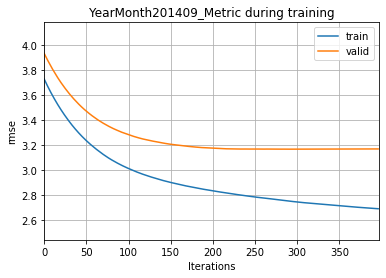

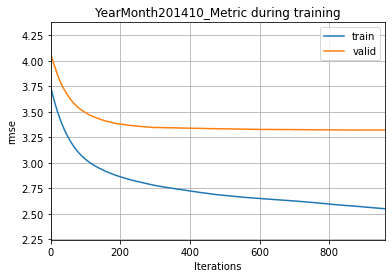

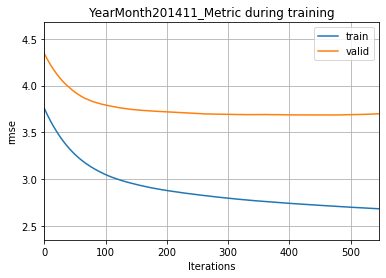

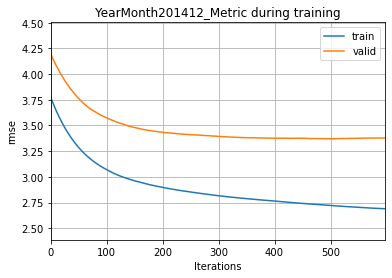

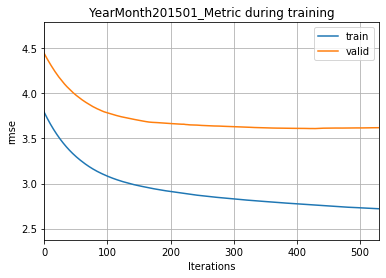

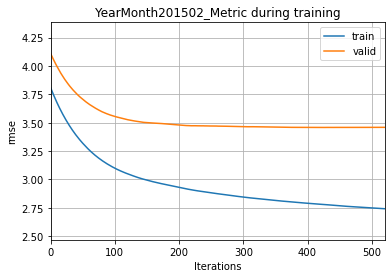

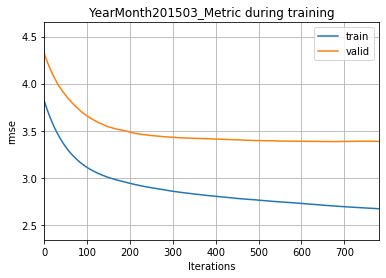

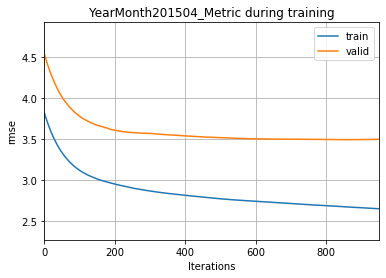

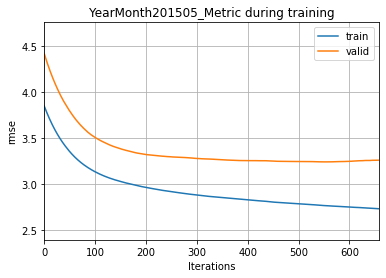

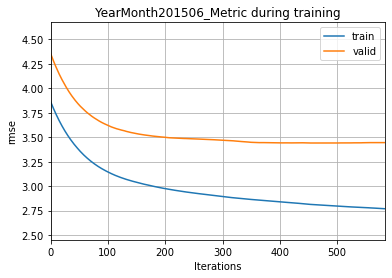

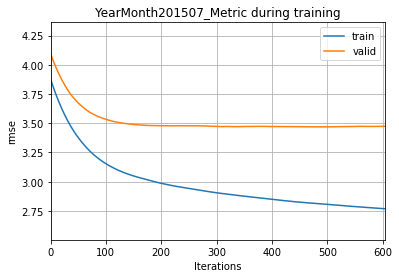

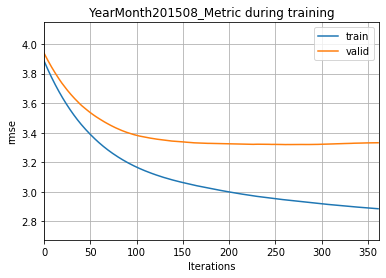

In [28]:
test_labels =[]
test_labels = pd.DataFrame(test_labels)
for x in range(4):
    year_month = str(201409 + x)
    utils(year_month)
    test_label, cv_score = train_predict(year_month)
    test_labels = pd.concat([test_labels, test_label])
    print(" ")
    
for x in range(1,9):
    year_month = str(201500 + x)
    utils(year_month)
    test_label, cv_score = train_predict(year_month)
    test_labels = pd.concat([test_labels, test_label])
    print(" ")
    
print("------------ " + " END" + " ------------") 
cv_score = float(sum(cv_score))/len(cv_score) 
print ("CV: ", cv_score)

# 出力

In [29]:
test_labels.columns = ["id", "pred"]
test_labels = pd.DataFrame(test_labels)

In [30]:
test_labels.head(2)

,id,pred
0,8761,12.444406
1,8762,12.444406


In [31]:
test_labels.shape

(193200, 2)

In [32]:
submission = test_labels
submission.to_csv("submission.csv",index=False, header=False)

In [33]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193200 entries, 0 to 16099
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      193200 non-null  int64  
 1   pred    193200 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 4.4 MB
